In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
#import pandas_profiling
import itertools

In [2]:
df=pd.read_csv('C:\\1\\1\\telco-customer-churn.csv')

# Предварительный анализ данных
### Воспользуемся pandas_profiling для анализа нашего датасета


In [3]:
#pandas_profiling.ProfileReport(df)

По полученным результатам выше видим что имеются два столбца 'noadditionallines' и 'year' которые мы можем исключить в качестве признаков для модели, т.к. они принимают одни и те же значения. 

Также находим что имеется корреляция между 'totalcallduration' и 'avgcallduration', попробуем оставить только 'avgcallduration'.

In [5]:
y_train1=df['churn']
df.drop(labels=['churn','noadditionallines','year','totalcallduration','callingnum'], axis=1, inplace=True)

In [6]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, MinMaxScaler,StandardScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

In [7]:
#Создадим класс для LabelEncoder чтобы в дальнейшем его использовать в pipline
class LabelEncoderPipelineFriendly(LabelEncoder):
    
    def fit(self, X, y=None):
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)

In [8]:
#Выделим столбцы с числовыми значениями
def get_numeric_col(df):
    return df[['age','annualincome','calldroprate','callfailurerate','customerid','monthlybilledamount','numberofcomplaints','numberofmonthunpaid','numdayscontractequipmentplanexpiring','penaltytoswitch','totalminsusedinlastmonth','unpaidbalance','percentagecalloutsidenetwork','avgcallduration','month']]
#Выделим столбцы boolean
def get_boolean_customersuspended(df):
    return df[['customersuspended']]
def get_boolean_gender(df):
    return df[['gender']]
def get_boolean_homeowner(df):
    return df[['homeowner']]
def get_boolean_maritalstatus(df):
    return df[['maritalstatus']]
def get_boolean_usesinternetservice(df):
    return df[['usesinternetservice']]
def get_boolean_usesvoiceservice(df):
    return df[['usesvoiceservice']]
#Выделим столбцы categorical
def get_categ_education(df):
    return df[['education']]
def get_categ_occupation(df):
    return df[['occupation']]
def get_categ_state(df):
    return df[['state']]



Воспользуемся pipeline (все числовые столбцы отмасштабируем через StandardScaler, столбцы с бинарными значенимя покажем как 0 и 1 (LabelEncoder), а остальные столбцы с категорияльными признаками применим OneHotEncoder, предварительно применив LabelEncoder

###### После этого все наши признаки будут иметь числовые значения

In [13]:
vec = make_union(*[
  make_pipeline(FunctionTransformer(get_numeric_col, validate=False),StandardScaler()),
        
  make_pipeline(FunctionTransformer(get_boolean_customersuspended, validate=False),  LabelEncoderPipelineFriendly()),
  make_pipeline(FunctionTransformer(get_boolean_gender, validate=False),  LabelEncoderPipelineFriendly()),
  make_pipeline(FunctionTransformer(get_boolean_homeowner, validate=False),  LabelEncoderPipelineFriendly()),
  make_pipeline(FunctionTransformer(get_boolean_maritalstatus, validate=False),  LabelEncoderPipelineFriendly()),
  make_pipeline(FunctionTransformer(get_boolean_usesinternetservice, validate=False),  LabelEncoderPipelineFriendly()),
  make_pipeline(FunctionTransformer(get_boolean_usesvoiceservice, validate=False),  LabelEncoderPipelineFriendly()),
     
  make_pipeline(FunctionTransformer(get_categ_education, validate=False),  LabelEncoderPipelineFriendly(),OneHotEncoder(sparse=False)),
  make_pipeline(FunctionTransformer(get_categ_occupation, validate=False),  LabelEncoderPipelineFriendly(),OneHotEncoder(sparse=False)),
  make_pipeline(FunctionTransformer(get_categ_state, validate=False),  LabelEncoderPipelineFriendly(),OneHotEncoder(sparse=False)),
])

In [17]:
x_train1=vec.fit_transform(df)
x_train1.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sa

(20468, 78)

In [20]:
#разобьем нашу выборку на test и train, на выборке train будем обучать модель, в том числе и подбирать параметры, а качество модели узнаем на test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train1, y_train1, test_size=0.1, random_state=42)

In [40]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_union, make_pipeline
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder,StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

In [129]:
model_log=RandomForestClassifier()
#model_log = tree.DecisionTreeClassifier()
#model_log = ExtraTreesClassifier(max_depth=40)
#model_log=AdaBoostClassifier()
#model_log=SGDClassifier(loss='log',random_state=1)
#model_log=LogisticRegression()
model_log.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [214]:
scorer='roc_auc'
n_fold=10
cv_strategy = StratifiedShuffleSplit(n_splits=n_fold,test_size=0.3, random_state=3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.90      1.00      0.95      1850
          1       0.00      0.00      0.00       197

avg / total       0.82      0.90      0.86      2047

accuracy: 0.9038
CV mean score(roc_auc): 0.6586 std: +/-0.01077
roc_auc on test: 0.6426
avg precision score: 0.0962


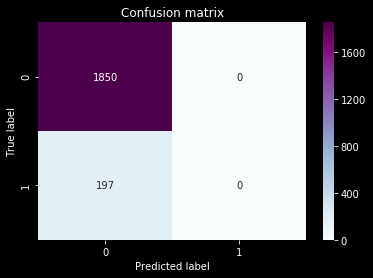

In [227]:
model_log=LogisticRegression()
model_log.fit(x_train, y_train)
log_predic=model_log.predict(x_test)
log_predic_proba=model_log.predict_proba(x_test)
ac_sc=metrics.accuracy_score(y_test,log_predic)

r = sns.heatmap(metrics.confusion_matrix(y_test,log_predic), cmap='BuPu', annot=True,fmt="d")
r.set_title("Confusion matrix")
r.set_xlabel("Predicted label")
r.set_ylabel("True label")

ac_sc=metrics.accuracy_score(y_test,log_predic)
print(metrics.classification_report(y_test,log_predic))
print('accuracy: {}' .format(round(ac_sc,4)))

mean1=cross_val_score(model_log,x_train1,y_train1,scoring=scorer,cv=cv_strategy).mean()
std1=cross_val_score(model_log,x_train1,y_train1,scoring=scorer,cv=cv_strategy).std()
print('CV mean score(roc_auc): {}' .format(round(mean1,4)),'std: +/-{}' .format(round(std1,5)))


roc_auc_test=metrics.roc_auc_score(y_test,log_predic_proba[:,1])
print('roc_auc on test: {}' .format(round(roc_auc_test,4)))

avg_prec=metrics.average_precision_score(y_test,log_predic)
print('avg precision score: {}' .format(round(avg_prec,4)))

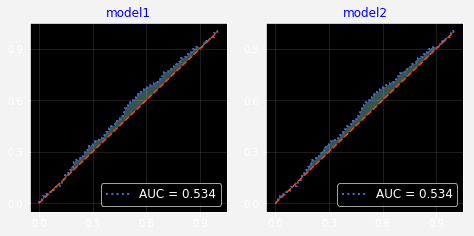

In [224]:
lst=[model_log,model_log]
length=len(lst)
mods=['model1','model2']
plt.style.use("dark_background")
fig=plt.figure(figsize=(12,16))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(x_test)
    predictions   = i.predict(x_test)
    fpr,tpr,thresholds = metrics.roc_curve(y_test,probabilities[:,1])
    plt.plot(fpr,tpr,linestyle = "dotted",
             color = "royalblue",linewidth = 2,
             label = "AUC = " + str(np.around(metrics.roc_auc_score(y_test,probabilities[:,1]),3)))
    plt.plot([0,1],[0,1],linestyle = "dashed",
             color = "orangered",linewidth = 1.5)
    plt.fill_between(fpr,tpr,alpha = .4)
    plt.fill_between([0,1],[0,1],color = "k")
    plt.legend(loc = "lower right",
               prop = {"size" : 12})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xticks(np.arange(0,1,.3))
    plt.yticks(np.arange(0,1,.3))

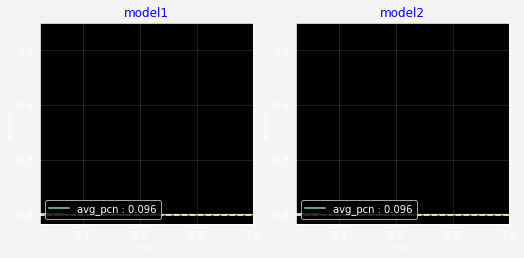

In [226]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


lst=[model_log,model_log]
length=len(lst)
mods=['model1','model2']

fig = plt.figure(figsize=(13,17))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(x_test)
    predictions   = i.predict(x_test)
    recall,precision,thresholds = precision_recall_curve(y_test,probabilities[:,1])
    plt.plot(recall,precision,linewidth = 1.5,
             label = ("avg_pcn : " + 
                      str(np.around(average_precision_score(y_test,predictions),3))))
    plt.plot([0,1],[0,0],linestyle = "dashed")
    plt.fill_between(recall,precision,alpha = .2)
    plt.legend(loc = "lower left",
               prop = {"size" : 10})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xlabel("recall",fontsize =7)
    plt.ylabel("precision",fontsize =7)
    plt.xlim([0.25,1])
    plt.yticks(np.arange(0,1,.3))